In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
def relu(x) -> np.ndarray:
    """
    ReLU activation function.
    """
    return np.maximum(x, 0)


def get_codes(vec: np.ndarray) -> np.ndarray:
    """
    Binarizes the input vector by setting strictly positive elements to 1 and non-positive elements to 0.

    This function takes a numpy array as input and returns a new array of the same shape with
    all strictly positive elements set to 1 and all other elements set to 0.

    Parameters
    ----------
    vec : np.ndarray
        The input numpy array to be binarized.

    Returns
    -------
    np.ndarray
        A numpy array of the same shape as the input `vec` with strictly positive elements set to 1
        and non-positive elements set to 0.

    """
    return np.atleast_1d((vec > 0).astype(int))


def SF_measure(max_range, eff_path) -> np.ndarray:
    """
    Computes the space foldings (SF) measure given a maximum range and effective path values.

    The space foldings (SF) measure is calculated by dividing the maximum range by the corresponding
    effective path values. Any resulting NaN or infinity values are replaced with 1.

    Parameters
    ----------
    max_range : float
        The maximum range value to be divided by the effective path values.
    eff_path : np.ndarray
        A numpy array containing the effective path values.

    Returns
    -------
    np.ndarray
        A numpy array of the same shape as `eff_path` with the calculated space foldings (SF) measure
        for each element. Any NaN or infinity values are replaced with 1.
    """
    helper = max_range / eff_path
    mask = np.logical_or(np.isnan(helper), np.isinf(helper))
    helper[mask] = 1
    return helper


def convex_combination(initial_point: np.ndarray,
                       final_point: np.ndarray,
                       weights: np.ndarray) -> np.ndarray:
    """
    Computes a convex combination of two points given an array of weights.

    The function takes two numpy arrays representing points and an array of weights. It calculates
    a convex combination of the two points for each weight, assuming the weights are increasing.
    The resulting array has the same shape as the input points and contains the convex combination
    of the two points for each corresponding weight.

    Parameters
    ----------
    initial_point : np.ndarray
        The initial point (numpy array) in the convex combination.
    final_point : np.ndarray
        The final point (numpy array) in the convex combination.
    weights : np.ndarray
        A numpy array containing the weights used for the convex combination. Each weight must be
        in the range [0, 1].

    Returns
    -------
    np.ndarray
        A numpy array of the same shape as the input points, containing the convex combination of
        the two points for each corresponding weight.

    Raises
    ------
    AssertionError
        If any weight is outside the range [0, 1].

    """
    assert min(weights) >= 0 and max(weights) <= 1, 'Weight outside of range'
    return np.expand_dims(1 - weights, axis=1) * initial_point + np.expand_dims(weights, axis=1) * final_point

# helper functions
def concat_or_reshape(current_x, previous_x):
    """
    Concatenate or reshape the current array with the previous one. If the arrays have different
    dimensions, it reshapes the current array to match the dimension of the previous one.

    Args:
        current_x (np.array): The current input array.
        previous_x (np.array): The previous input array.

    Returns:
        np.array: A concatenated or reshaped array.
    """
    current_codes = get_codes(current_x)
    if previous_x.size == 0:
        return current_codes

    if current_codes.ndim == 1:
        current_codes = current_codes.reshape(-1, 1)

    try:
        return np.concatenate((previous_x, current_codes), axis=1)
    except ValueError:
        return np.concatenate((previous_x, np.atleast_2d(current_codes)), axis=1)
    
    
def zero_if_close(vec: np.array) -> np.array:
    """
    Adjusts the input vector by replacing elements close to zero with zero.

    This function checks if all elements in the input vector `vec` are close enough to zero within
    a specified tolerance. If they are, the function returns a vector of the same shape with all elements
    set to zero. If not, the input vector is returned unchanged.

    Parameters
    ----------
    vec : np.array
        The input vector (numpy array) to be checked and potentially adjusted for numerical precision issues.

    Returns
    -------
    np.array
        A numpy array of the same shape as `vec` with elements close to zero replaced by zero, or the
        original input vector if no elements are close enough to zero.
    """
    if np.allclose(vec, np.zeros(vec.shape), rtol=1e-17):
        return np.atleast_1d(np.zeros(vec.shape))
    else:
        return vec


In [3]:
def get_weights_A(n_recursions: int) -> list:
    """
    Generates a list of weights for a neural network (Repr. A) with a specific number of recursions.

    This function constructs a list of weights and biases for a neural network with `n_recursions`
    number of layers. The weights and biases are defined as numpy arrays. The resulting list
    contains tuples, where the first element is a weight matrix and the second element is a bias
    vector.

    Parameters
    ----------
    n_recursions : int
        The number of recursions (layers) in the neural network for which the weights will be generated.

    Returns
    -------
    list
        A list of tuples containing the weights and biases for each layer in the neural network.
        Each tuple contains a weight matrix as the first element and a bias vector as the second element.

    """
    W_1 = np.array([[3, 0], [-3, 0], [0, 1]])
    b_1 = np.array([-2, 1, 0])
    W_2 = np.array([[1, 1, 0], [0, 0, 1]])
    # the last layer
    W_top = np.array([-1 / 2, 1])
    b_top = np.array([-1 / 2])

    weights = []
    for _ in range(n_recursions):
        weights.append([W_1, b_1])
        weights.append(W_2)

    weights.append([W_top, b_top])
    return weights


# weights for representation B and C

def weights_odd_elem_case(weight_array) -> np.ndarray:
    """
    Transforms the weight array to handle the odd element case.

    This function takes a weight array and modifies it by adding rows and columns to handle the
    odd element case. The resulting array has one more column and two more rows than the input array.

    Parameters
    ----------
    weight_array : np.ndarray
        The input weight array to be transformed.

    Returns
    -------
    np.ndarray
        The transformed weight array with an additional column and two additional rows.
    """
    weight_array = np.c_[weight_array, np.zeros(weight_array.shape[0])]
    # np.concatenate((weight_array, np.zeros((weight_array.shape[0], 1))), axis=1)
    helper = np.zeros((2, weight_array.shape[1]))
    helper[0, -1] = 1
    helper[1, -1] = -1
    weight_array = np.r_[weight_array, helper]
    return weight_array


def signs_odd_elem_case(signs_array) -> np.ndarray:
    """
    Transforms the signs array to handle the odd element case.

    This function takes a signs array and modifies it by adding rows and columns to handle the
    odd element case. The resulting array has one more row and two more columns than the input array.

    Parameters
    ----------
    signs_array : np.ndarray
        The input signs array to be transformed.

    Returns
    -------
    np.ndarray
        The transformed signs array with an additional row and two additional columns.

    """
    weight_array = np.r_[signs_array, np.zeros(signs_array.shape[1])[np.newaxis, :]]
    helper = np.zeros((2, weight_array.shape[0])).T
    helper[-1, -1] = -1
    helper[-1, -2] = 1
    weight_array = np.c_[weight_array, helper]
    return weight_array


class PrepareWeights:
    """
    For preparing weights of representations B and C
    """

    def __init__(self, representation: str):

        if representation == 'B':
            self.A = np.array([[0, 1], [0, -1], [-1, 1]])
            self.S = np.array([1, -1, -1])
        elif representation == 'C':
            self.A = np.array([[1, 1], [-1, -1], [-1, 1], [1, -1]])
            self.S = np.array([1, -1, -1, -1]) / 2
        else:
            raise ValueError(f'Unknown representation {representation}')

    def min_representation_by_relus(self, vec: np.ndarray) -> tuple:
        """
        Prepare ReLU architecture to describe minimum function.
        """
        n = vec.T.shape[0]  # vec.shape[1] if vec.ndim == 2 else vec.shape[0]
        n += (n + 1) % 2  # add 1 if n is even else 0
        S_1 = np.kron(np.eye((n - 1) // 2), self.S)
        W_1 = np.kron(np.eye((n - 1) // 2), self.A)
        if vec.T.shape[0] % 2:
            W_1 = weights_odd_elem_case(np.squeeze(W_1))  # expand and attach 1 and -1
            S_1 = signs_odd_elem_case(S_1)

        return S_1, W_1, relu(W_1 @ vec.T)

    def output_weights(self, arr: np.ndarray) -> list:
        """
        For representations B & C
        """
        arr = np.squeeze(arr)
        weights = []
        S_m_holder = None
        while arr.shape[0] > 1:  # nb of (repeated) hyperplanes
            S_m, W_m, pre_code = self.min_representation_by_relus(arr.T)
            arr = S_m @ pre_code
            # W_m is the first weight matrix by which we matmul the input
            weights.append(W_m if S_m_holder is None else W_m @ S_m_holder)
            S_m_holder = S_m  # previous value of S_m
        weights.append(self.S)
        return weights

In [4]:
# for creating hyperplanes of CantorNet

def get_y_coordinates(nb_recursion: int) -> np.ndarray:
    """
    Get y coordinates of the ragged shape, alternating between 1 and 1/2.

    :param nb_recursion: Number of times the ragged surface will oscillate between 1 and 1/2
    :return: NumPy array with y coordinates
    """
    y_coord = np.repeat([1, 1 / 2], 2).tolist()
    y_coord = np.ravel([y_coord] * np.power(2, nb_recursion))
    y_coord = np.append(y_coord[1:], 1)
    return y_coord


def match_coordinates(x_coord, y_coord) -> tuple:
    """
    Match x_coord with y_coord to prepare points for hyperplane calculations.

    :param x_coord: NumPy array with x coordinates
    :param y_coord: NumPy array with y coordinates
    :return: Generator yielding pairs of points
    """
    x_coord = np.ravel(x_coord)
    joint_coord = np.c_[x_coord, y_coord]
    for coord_set1, coord_set2 in zip(joint_coord[:-1], joint_coord[1:]):
        yield coord_set1, coord_set2


def cantor(line_segment=[(0, 1)]):
    """
    Yield points which are the beginning and end of intervals removed from the Cantor set.

    :param line_segment: Initial interval
    :return: Generator yielding line segments
    """
    third = lambda interval: (interval[1] - interval[0]) / 3
    while True:
        yield line_segment
        line_segment = [((k[0], k[0] + third(k)), (k[1] - third(k), k[1])) for k in line_segment]
        line_segment = reduce(lambda x, y: x + y, line_segment)


def get_coord_batches(n_recursions):
    """
    Get pairs of points for determining hyperplane equations.

    :param n_recursions: Number of recursions for Cantor set
    :return: Generator yielding pairs of points
    """
    get_x_coordinates = {}
    g = cantor()

    for i in range(n_recursions + 1):
        get_x_coordinates[str(i)] = next(g)

    del get_x_coordinates['0']

    y_coord = get_y_coordinates(n_recursions - 1)
    coord_batches = match_coordinates(get_x_coordinates[str(n_recursions)], y_coord)
    return coord_batches


def get_hyperplane_equation(coord_batch) -> tuple:
    """
    Returns coefficients of a general equation of a hyperplane.

    :param coord_batch: NumPy array containing coordinates for two points
    :return: Tuple with coefficients of the hyperplane equation
    """
    x1, y1, x2, y2 = coord_batch
    assert x1 != x2, "Degenerate points, can't fit a hyperplane."
    A = y1 - y2
    B = x2 - x1
    C = x1 * y2 - x2 * y1
    return [A, B], C


def get_ABC_coeff(n_recursions: int) -> tuple:
    """
    Get A, B, C coefficients of general hyperplane equations.

    :param n_recursions: Number of recursions for Cantor set
    :return: Tuple with lists of coefficients A, B and C
    """
    coord_batches = get_coord_batches(n_recursions)

    AB_coeff, C_coeff = [], []
    for coord_batch in coord_batches:
        AB, C = get_hyperplane_equation(np.ravel(coord_batch))
        AB_coeff.append(AB)  #
        C_coeff.append(C)

    return AB_coeff, np.ravel(C_coeff)

In [5]:
def get_weights(n_recursions: int, points: np.ndarray, representation: str) -> np.ndarray:
    """
    Calculate weights based on the specified representation.

    Args:
        n_recursions (int): The number of recursions.
        points (np.ndarray): The points to transform.
        representation (str): The representation type ('A', 'B', or 'C').

    Returns:
        np.ndarray: The calculated weights.

    Raises:
        ValueError: If an unknown representation is provided.
    """

    coeff_ab, coeff_c = get_ABC_coeff(n_recursions)
    # matrix multiply points with hyperplanes coefficients, later recover the shapes
    y = np.matmul(coeff_ab, points.T)  # y=hyperplane_values
    y += coeff_c if points.ndim == 1 else coeff_c[:, np.newaxis]

    if n_recursions == 1:
        cantor_shape = y
    else:
        dents = [np.max([y[4 * k - 2], y[4 * k - 1], y[4 * k]], axis=0) for k in range(1, y.shape[0] // 4 + 1)]
        try:
            cantor_shape = np.vstack((y[0], y[1], y[-1], np.asarray(dents)))
        except ValueError:
            cantor_shape = np.hstack((y[0], y[1], y[-1], np.asarray(dents)))

    prepare_weights = PrepareWeights(representation=representation)
    weights = prepare_weights.output_weights(relu(cantor_shape))
    weights.insert(0, relu(cantor_shape))
    return weights


# functions to get Hamming distances necessary for the computation of space foldings measure
def get_hamming_distances_A(weights, x1, x2):
    """
    Get Hamming distances between the input points x1 and x2 for representation A
    :param weights: list of weights for each layer
    :param x1: first input point
    :param x2: second input point
    :return: list of Hamming distances
    """
    codes_x1 = np.empty(0)
    codes_x2 = np.empty(0)
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    for weight in weights:
        w, b = (weight[0], weight[1]) if isinstance(weight, list) else (weight, 0)
        x1 = relu(np.matmul(w, x1.T).T + b)
        x2 = relu(np.matmul(w, x2.T).T + b)

        codes_x1 = concat_or_reshape(current_x=get_codes(x1), previous_x=codes_x1)
        codes_x2 = concat_or_reshape(current_x=get_codes(x2), previous_x=codes_x2)

    dists = np.sum(codes_x1 != codes_x2, axis=1) if codes_x1.ndim == 2 else np.sum(codes_x1 != codes_x2)
    return dists


def get_hamming_distances_BC(weights, weights2):
    """
    Calculate the Hamming distances between two sets of weights using representation B and C.

    Args:
        weights (array-like): The first set of weights.
        weights2 (array-like): The second set of weights.

    Returns:
        list: A list of Hamming distances between the two sets of weights.
    """
    codes_x1 = np.empty(0)
    codes_x2 = np.empty(0)

    for idx, (weight1, weight2) in enumerate(zip(weights, weights2)):
        if idx == 0:
            x1, x2 = weight1, weight2  # init weights[0] (B and C were already multiplied)
        else:
            x1 = zero_if_close(relu(weight1 @ x1))
            x2 = zero_if_close(relu(weight2 @ x2))

        try:
            codes_x1 = np.concatenate((codes_x1, get_codes(x1)))  # if codes_x1 is a vector and codes_x2 is a matrix
        except ValueError:
            codes_x1 = np.concatenate((codes_x1, np.atleast_2d(get_codes(x1)))) if codes_x1.size else get_codes(x1)

        codes_x2 = np.concatenate((codes_x2, np.atleast_2d(get_codes(x2)))) if codes_x2.size else get_codes(x2)

    dists = np.sum(codes_x1 != codes_x2, axis=0) if codes_x1.ndim == 2 else np.sum(codes_x1 != codes_x2.T, axis=1)

    return dists


# get space folding measurements

def measure_range(x_1: np.ndarray,
                  x_2: np.ndarray,
                  weights: np.ndarray,
                  n_recursions: int,
                  representation: str) -> tuple:
    """
    for measuring space foldedness, returning nominator & denominator
    """
    assert representation in ('A', 'B', 'C'), f'Unknown representation {representation}'
    points_in_between = convex_combination(x_1, x_2, weights)

    if representation in ('B', 'C'):
        weights_initial_point = get_weights(points=points_in_between[0],
                                            n_recursions=n_recursions,
                                            representation=representation)

        weights_points_between = get_weights(points=points_in_between,
                                             n_recursions=n_recursions,
                                             representation=representation)  # inputs are always 2d

        delta = get_hamming_distances_BC(
            weights_initial_point,
            [weights_points_between[0][:, 1:]] + weights_points_between[1:]
        )

        eff_path = get_hamming_distances_BC(
            [weights_points_between[0][:, :-1]] + weights_points_between[1:],
            [weights_points_between[0][:, 1:]] + weights_points_between[1:]
        )
    else:
        weights = get_weights_A(n_recursions)
        delta = get_hamming_distances_A(weights=weights, x1=x_1, x2=points_in_between[1:])
        # max_n | \sum_{i=1}^n [ d(\pi_{i+1},\pi_1) - d(\pi_i,\pi_1) ] |
        eff_path = get_hamming_distances_A(weights=weights, x1=points_in_between[:-1], x2=points_in_between[1:])

    return np.asarray(delta), np.asarray(eff_path)


def get_space_foldings_measure(X_1: np.ndarray, X_2: np.ndarray, representation: str) -> list:
    """
    Calculate space-folding measure between two sets of points in a given representation.

    Parameters:
    X_1 (np.ndarray): First set of points.
    X_2 (np.ndarray): Second set of points.
    representation (str): Type of representation for calculating the measure.

    Returns:
    np.ndarray: Space-folding measure between X_1 and X_2.
    """
    sf_measure_ = []
    for n_recursions in range(1, 6):
        delta, eff_path = measure_range(X_1, X_2, np.arange(0, 11, 1) / 10, n_recursions, representation)
        sf_measure = SF_measure(max_range=np.maximum.accumulate(delta), eff_path=np.cumsum(eff_path))
        sf_measure_.append(sf_measure)
    return sf_measure_

In [10]:
from matplotlib.cm import get_cmap

def sf_measure_cantornet(sf_measure_):
    x = np.arange(1, 11, 1) / 10
    labels = ['k=1', 'k=2', 'k=3', 'k=4', 'k=5']
    greys = get_cmap('Greys')
    linestyles = ['-', '--', '-.', ':', '-']
    for i, sf_measure in enumerate((1 - np.asarray(sf_measure_))):
        plt.plot(x, sf_measure, label=labels[i], color=greys((i + 1) * 0.2), linestyle=linestyles[i])
    
    plt.xlabel('Step')
    plt.ylim(0, .95)
#     plt.grid()
    plt.xticks(x, x)  # to display every value on x-axis
    plt.ylabel('Space Folding')
    plt.legend(fontsize=12)
    plt.show()

C:\Users\LEWAND~1\AppData\Local\Temp/ipykernel_864/3985490456.py:50: RuntimeWarning: invalid value encountered in true_divide
  helper = max_range / eff_path


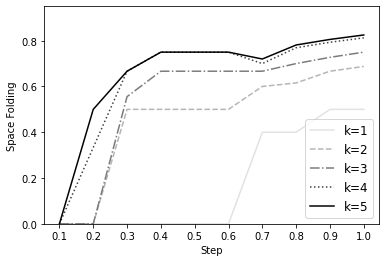

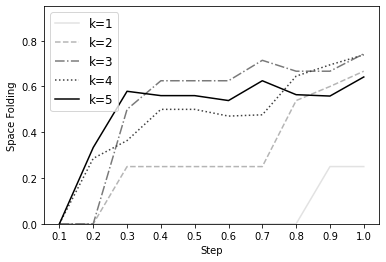

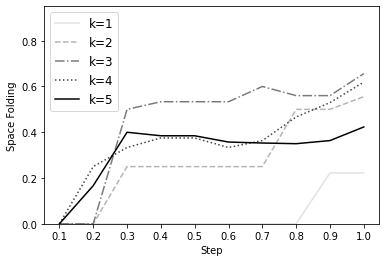

In [11]:
sf_measure_A = get_space_foldings_measure(np.array([0, 3 / 4]), np.array([1, 3 / 4]), 'A')
sf_measure_B = get_space_foldings_measure(np.array([0, 3 / 4]), np.array([1, 3 / 4]), 'B')
sf_measure_C = get_space_foldings_measure(np.array([0, 3 / 4]), np.array([1, 3 / 4]), 'C')
sf_measure_cantornet(sf_measure_A)
sf_measure_cantornet(sf_measure_B)
sf_measure_cantornet(sf_measure_C)